# Tutorial 2: Simulating Networks

In this tutorial, we create a network with excitatory, inhibitory, and modulatory synaptic connections. We also add input sources and output monitors, and simulate the network using a `numpy` backend.

## Step 1: Import necessary packages

In [1]:
# Add the library to the path
# If jupyter cannot find SNS-Toolbox
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import packages and modules for designing the network
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.networks import Network

# Import packages and modules for simulating the network
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Define Network Component Presets

Now that we've imported all of our prerequisites, we can start building the network. We begin with defining the same neuron and synapses presets we defined in Tutorial 1.

In [2]:
# Define a non-spiking neuron and excitatory/inhibitory connections as in tutorial_1
neuron_type = NonSpikingNeuron()
synapse_excitatory = NonSpikingSynapse(max_conductance=1.0, relative_reversal_potential=50.0)
synapse_inhibitory = NonSpikingSynapse(max_conductance=1.0, relative_reversal_potential=-40.0)

Next we define a modulatory synapse. The defining characteristic of a modulatory synapse is that the relative reversal potential is equal to the resting potential, so in our case that means 0 mV. Modulatory synapses by themselves don't induce a response in the postsynaptic neuron, but instead reduce the effective strength of the other synapses terminating at the postsynaptic neuron.

In [3]:
# Define a modulatory synapse (relative reversal potential is 0)
synapse_modulatory = NonSpikingSynapse(max_conductance=1.0, relative_reversal_potential=0.0)

## Step 3: Construct the Network

Now we begin constructing the network. First we create an empty network.

In [4]:
net = Network(name='Tutorial 2 Network', R=20.0)

Next we add a neuron, which will receive an external input, and a neuron which is excited by the source neuron. We connect them with an excitatory synapse.

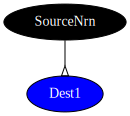

In [5]:
# Make a neuron to receive external input
net.add_neuron(neuron_type, name='SourceNrn', color='black')

# Make a neuron which is excited by the source neuron
net.add_neuron(neuron_type, name='Dest1', color='blue')
net.add_connection(synapse_excitatory, 'SourceNrn', 'Dest1')

net.graph # Display the network graph in this notebook

We add two more neurons. One is excited by the source and excites the other, the other inhibits the first.

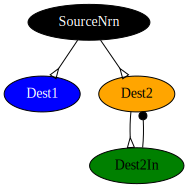

In [6]:
net.add_neuron(neuron_type, name='Dest2', color='orange')
net.add_neuron(neuron_type, name='Dest2In', color='green')
net.add_connection(synapse_excitatory, 'SourceNrn', 'Dest2')
net.add_connection(synapse_excitatory, 'Dest2', 'Dest2In')
net.add_connection(synapse_inhibitory, 'Dest2In', 'Dest2')

net.graph

We make one more neuron, which will be excited by the source neuron and modulated by Dest1.

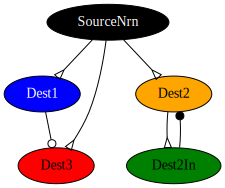

In [7]:
net.add_neuron(neuron_type, name='Dest3', color='red')
net.add_connection(synapse_excitatory, 'SourceNrn', 'Dest3')
net.add_connection(synapse_modulatory, 'Dest1', 'Dest3')

net.graph

Now we need to add an input source, so that during simulation we can apply an external stimulus to the source neuron.

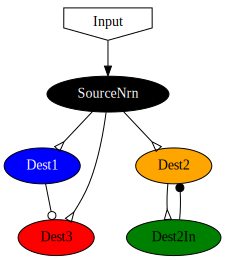

In [8]:
net.add_input(dest='SourceNrn', name='Input', color='white')

net.graph

Finally we add output monitors, so that we can view the state of each neuron in the network.

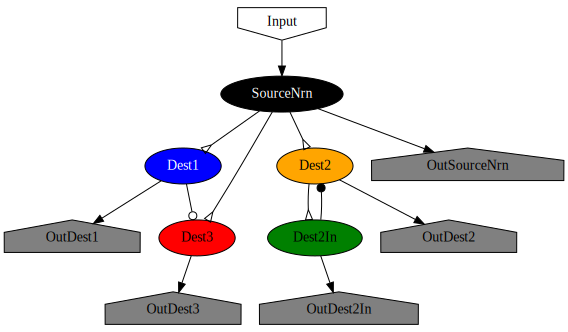

In [9]:
net.add_output('SourceNrn', name='OutSourceNrn', color='grey')
net.add_output('Dest1', name='OutDest1', color='grey')
net.add_output('Dest2', name='OutDest2', color='grey')
net.add_output('Dest2In', name='OutDest2In', color='grey')
net.add_output('Dest3', name='OutDest3', color='grey')

net.graph

## Step 4: Compile the Network

Now that we have built a description of our network, we need to compile it to the backend of our choice and simulate it. In our case we will be compiling to a `numpy` representation.

First, we start by setting some general parameters for the simulation.

In [10]:
# Set simulation parameters
dt = 0.01 # Simulation timestep in ms
t_max = 50 # Max simulation time in ms

# Initialize a vector of timesteps
t = np.arange(0, t_max, dt)

# Initialize vectors which store the input to our network, and for data to be written to during simulation from outputs
inputs = np.zeros([len(t),1])+20.0  # Input vector must be 2d, even if second dimension is 1
data = np.zeros([len(t),5])

Next we compile the network. We pass in the network blueprint, our timestep, and an optional debug flag (if you want to see the individual steps in the compilation process, set `debug` to `True`). Our network also has no spiking neurons, so for faster execution we set `spiking` to `False` (In future versions this will be automatic).

In [11]:
model = net.compile(backend='numpy', dt=dt)

## Step 5: Simulate the Network

Now we can simulate the network. We create a loop, and at every timestep we apply the current input to a forward pass of the network. At each step we also store the results in `data`.

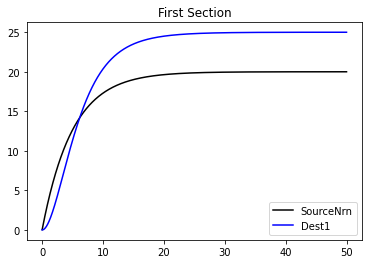

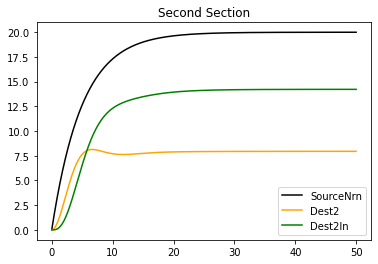

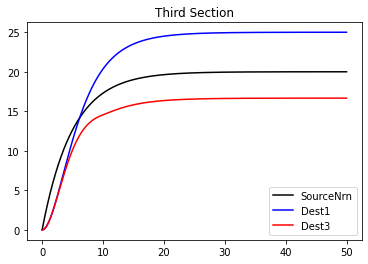

In [12]:
for i in range(len(t)):
    data[i,:] = model(inputs[i,:])
data = data.transpose() # Rearrange the data axes for easier plotting

"""Plot the data"""
# First section
plt.figure()
plt.title('First Section')
plt.plot(t,data[:][0],label='SourceNrn',color='black')  # When plotting, all data needs to be transposed first
plt.plot(t,data[:][1],label='Dest1',color='blue')
plt.legend()

# Second section
plt.figure()
plt.title('Second Section')
plt.plot(t,data[:][0],label='SourceNrn',color='black')
plt.plot(t,data[:][2],label='Dest2',color='orange')
plt.plot(t,data[:][3],label='Dest2In',color='green')
plt.legend()

# Third section
plt.figure()
plt.title('Third Section')
plt.plot(t,data[:][0],label='SourceNrn',color='black')
plt.plot(t,data[:][1],label='Dest1',color='blue')
plt.plot(t,data[:][4],label='Dest3',color='red')
plt.legend()

plt.show()  # Show the plots